## Train CFM

In [6]:
import numpy as np
import torch
from DynGenModels.configs.lhco_configs import LHCOlympics_HighLevel_MLP_CondFlowMatch as Configs

configs_fwd = Configs(# data:
                  DATA = 'LHCOlympicsHighLevel',
                  dataset = '../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5', 
                  cuts_sideband_low = {'mjj': [1500, 3200]}, #{'mjj': [2600, 3200]},  #{'mjj': [2700, 3300]},  
                  cuts_sideband_high = {'mjj': [3800, 5500]},  #{'mjj': [3800, 4400]}, #{'mjj': [3800, 6000]}, 
                  preprocess = ['normalize'],
                  dim_input = 5,
                  num_dijets = 115468, #75166,  
                  # training params:   
                  DEVICE = 'cuda:2',
                  EPOCHS = 100,
                  batch_size = 1024,
                  print_epochs = 10,
                  early_stopping = 30,
                  min_epochs = 200,
                  augmented = False,
                  exchange_target_with_source = False,
                  data_split_fracs = [0.85, 0.15, 0.0],
                  lr = 1e-3,
                  optimizer = 'Adam',
                  fix_seed = 12345,
                  # model params:
                  DYNAMICS = 'SchrodingerBridgeFlowMatching', 
                  MODEL = 'MLP_fwd',
                  dim_hidden = 256,
                  dim_time_emb = 128,
                  num_layers = 3,
                  activation = 'ReLU',
                  sigma = 0.0,
                  t0 = 0.0,
                  t1 = 1.0,
                  # sampling params:
                  solver = 'midpoint',
                  num_sampling_steps = 1000
                )

configs_fwd.set_workdir(path='../../results', save_config=True)

#==================================================================================================================
INFO: created directory: ../../results/LHCOlympicsHighLevel.SchrodingerBridgeFlowMatching.MLP_fwd.2023.12.10_21h29
#==================================================================================================================
+-----------------------------+--------------------------------------------------------------------------+
| Parameters                  | Values                                                                   |
+-----------------------------+--------------------------------------------------------------------------+
| DATA                        | LHCOlympicsHighLevel                                                     |
| dataset                     | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features                    | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.85/0.15/0.0
INFO: train size: 98147, validation size: 17320, testing sizes: 0


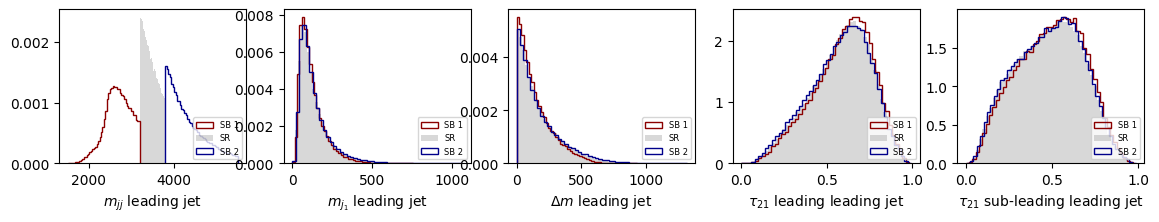

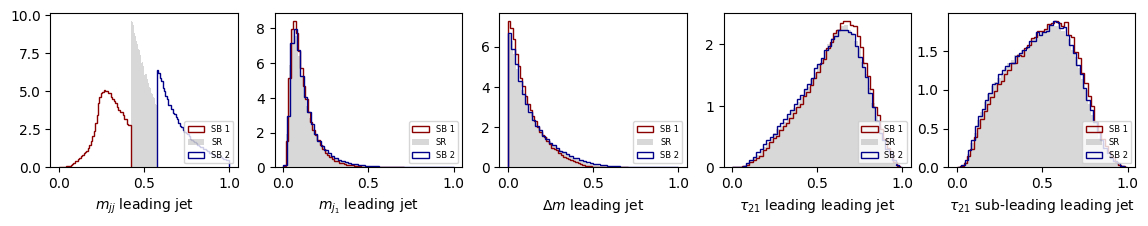

number of training parameters: 233349
number of training parameters: 233349
start training...
start training...


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

	Epoch: 1, train loss: 0.00267547801922774, valid loss: 0.002599913804956219  (min valid loss: 0.002599913804956219)
	Epoch: 1, train loss: 0.00267547801922774, valid loss: 0.002599913804956219  (min valid loss: 0.002599913804956219)
	Epoch: 11, train loss: 0.0024824331679459033, valid loss: 0.002218553248573752  (min valid loss: 0.0021734478376696214)
	Epoch: 11, train loss: 0.0024824331679459033, valid loss: 0.002218553248573752  (min valid loss: 0.0021734478376696214)
	Epoch: 21, train loss: 0.0022792134805058595, valid loss: 0.0022393449017887607  (min valid loss: 0.002064779414521421)
	Epoch: 21, train loss: 0.0022792134805058595, valid loss: 0.0022393449017887607  (min valid loss: 0.002064779414521421)
	Epoch: 31, train loss: 0.002278393025335391, valid loss: 0.0024084644666051164  (min valid loss: 0.0019266362411572654)
	Epoch: 31, train loss: 0.002278393025335391, valid loss: 0.0024084644666051164  (min valid loss: 0.0019266362411572654)
	Epoch: 41, train loss: 0.00213956050113

In [7]:
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsHighLevelDataset
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import SchrodingerBridgeFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

import torch
import numpy as np
import matplotlib.pyplot as plt

lhco_fwd = LHCOlympicsHighLevelDataset(configs_fwd)
cfm_fwd  = DynGenModelTrainer(dynamics = SchrodingerBridgeFlowMatching(configs_fwd),
                              model = MLP(configs_fwd), 
                              dataloader = LHCOlympicsDataLoader(lhco_fwd , configs_fwd), 
                              configs = configs_fwd)

#...plot data:

from utils import plot_sideband_data

plot_sideband_data(SB1=lhco_fwd.source, 
                   SR=lhco_fwd.background, 
                   SB2=lhco_fwd.target,
                   features=[r'$m_{jj}$', r'$m_{j_1}$', r'$\Delta m$', r'$\tau_{21}$ leading', r'$\tau_{21}$ sub-leading'],
                   bins=(50,50,50,50,50),
                   figsize=(14,2),
                   ) 

plot_sideband_data(SB1=lhco_fwd.source_preprocess, 
                   SR=lhco_fwd.background_preprocess, 
                   SB2=lhco_fwd.target_preprocess,
                   features=[r'$m_{jj}$', r'$m_{j_1}$', r'$\Delta m$', r'$\tau_{21}$ leading', r'$\tau_{21}$ sub-leading'],
                   bins=(50,50,50,50,50),
                   figsize=(14,2),
                   ) 


#...train model:

cfm_fwd.train()

In [4]:
lhco_fwd.source.shape, lhco_fwd.target.shape

(torch.Size([691995, 5]), torch.Size([115468, 5]))

In [ ]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PreProcessLHCOlympicsHighLevelData, PostProcessLHCOlympicsHighLevelData

pipeline_fwd = FlowMatchPipeline(trained_model=cfm_fwd, 
                                 configs=configs_fwd, 
                                 preprocessor=PreProcessLHCOlympicsHighLevelData,
                                 postprocessor=PostProcessLHCOlympicsHighLevelData,
                                 best_epoch_model=True)

pipeline_fwd.generate_samples(input_source=lhco_fwd.source)

from utils import plot_interpolation

mjj_buffer = 20

plot_interpolation(lhco_fwd, 
                   pipeline_fwd, 
                   figsize=(18,4.5),
                   mass_window=[configs_fwd.cuts_sideband_low['mjj'][1] + mjj_buffer, configs_fwd.cuts_sideband_high['mjj'][0] - mjj_buffer], 
                   bins=[(2500, 4500, 15), (0, 1200, 20), (-1250, 1250, 40), (0, 1.1, 0.02), (0, 1.1, 0.02)], 
                   log=False, 
                   density=True)

### 2. Backward transport SB2->SB1

In [ ]:
import numpy as np
import torch
from DynGenModels.configs.lhco_configs import LHCOlympics_HighLevel_MLP_CondFlowMatch as Configs

configs_bwd = Configs(# data:
                  DATA = 'LHCOlympics',
                  dataset = '../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5', 
                  cuts_sideband_low = {'mjj': [2600, 3300]},  #{'mjj': [2700, 3300]},  
                  cuts_sideband_high = {'mjj': [3700, 13000]}, #{'mjj': [3800, 6000]}, 
                  preprocess = ['normalize'],
                  dim_input = 5,
                  num_dijets = 143871, #66650,  
                  # training params:   
                  DEVICE = 'cpu',
                  EPOCHS = 100,
                  batch_size = 512,
                  print_epochs = 20,
                  early_stopping = 30,
                  min_epochs = 200,
                  exchange_target_with_source = True,
                  data_split_fracs = [0.9, 0.1, 0.0],
                  lr = 5e-4,
                  optimizer = 'Adam',
                  fix_seed = 1234,
                  # model params:
                  DYNAMICS = 'OptimalTransportFlowMatching', 
                  MODEL = 'MLP_bwd',
                  dim_hidden = 256,
                  num_layers = 3,
                  sigma = 0.0,
                  t0 = 0.0,
                  t1 = 1.0,
                  # sampling params:
                  solver = 'midpoint',
                  num_sampling_steps = 1000
                )

configs_bwd.set_workdir(path='../../results', save_config=True)

#========================================================================================================
INFO: created directory: ../../results/LHCOlympics.OptimalTransportFlowMatching.MLP_bwd.2023.11.25_23h24
#========================================================================================================
+-----------------------------+--------------------------------------------------------------------------+
| Parameters                  | Values                                                                   |
+-----------------------------+--------------------------------------------------------------------------+
| DATA                        | LHCOlympics                                                              |
| dataset                     | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features                    | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input                   | 5        

In [ ]:
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsHighLevelDataset
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.condflowmatch import OptimalTransportFlowMatching
from DynGenModels.trainer.trainer import DynGenModelTrainer

lhco_bwd = LHCOlympicsHighLevelDataset(configs_bwd, exchange_target_with_source=True)
cfm_bwd = DynGenModelTrainer(dynamics = OptimalTransportFlowMatching(configs_bwd),
                         model = MLP(configs_bwd), 
                         dataloader = LHCOlympicsDataLoader(lhco_bwd, configs_bwd), 
                         configs = configs_bwd)

#...train model:

cfm_bwd.train()

number of training parameters: 134661
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.9/0.1/0.0
INFO: train size: 129483, validation size: 14387, testing sizes: 0


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

	Epoch: 1, train loss: 0.001961953018188271, valid loss: 0.0022179599658682424  (min valid loss: 0.002053728463642042)
	Epoch: 21, train loss: 0.0017785635466683713, valid loss: 0.001855955784337531  (min valid loss: 0.001855955784337531)
	Epoch: 41, train loss: 0.0017756902103831362, valid loss: 0.001838844558545228  (min valid loss: 0.0018340327359479048)
	Epoch: 61, train loss: 0.0017560391434700247, valid loss: 0.00184009508390365  (min valid loss: 0.0018316369728538493)
	Epoch: 81, train loss: 0.001758627942763269, valid loss: 0.001845237943504391  (min valid loss: 0.0018272070045550835)


INFO: neural ODE solver with midpoint method and steps=1000


/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


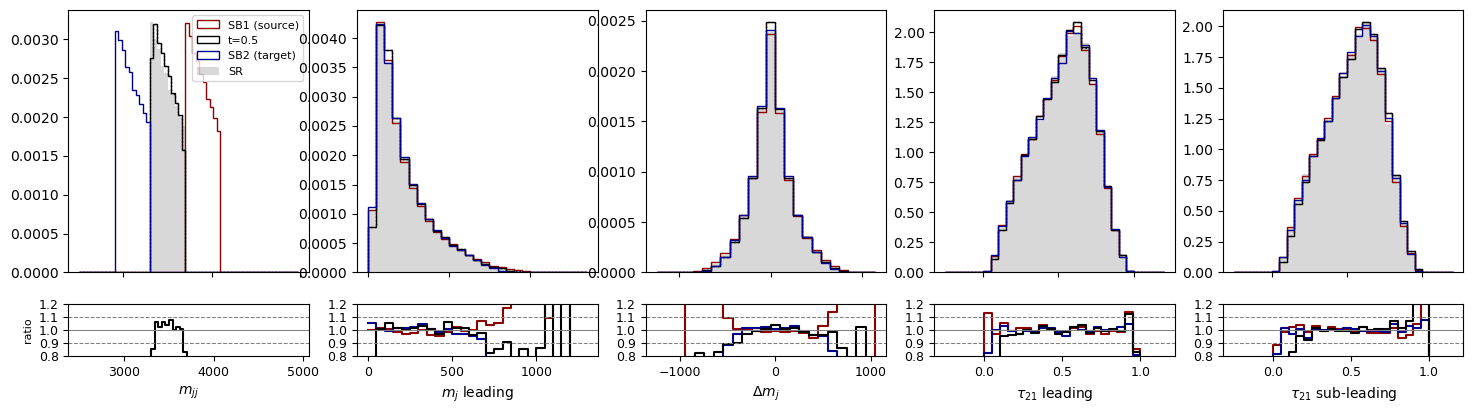

In [ ]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PreProcessLHCOlympicsHighLevelData, PostProcessLHCOlympicsHighLevelData

pipeline_bwd = FlowMatchPipeline(trained_model=cfm_bwd, 
                                configs=configs_bwd, 
                                preprocessor=PreProcessLHCOlympicsHighLevelData,
                                postprocessor=PostProcessLHCOlympicsHighLevelData,
                                best_epoch_model=True)

pipeline_bwd.generate_samples(input_source=lhco_bwd.source)

from utils import plot_interpolation

plot_interpolation(lhco_bwd, 
                   pipeline_bwd, 
                   figsize=(18,4.5),
                   mass_window=[configs_bwd.cuts_sideband_low['mjj'][1], configs_bwd.cuts_sideband_high['mjj'][0]], 
                   bins=[(2500, 5000, 40), (0, 1400, 50), (-1250, 1250, 100), (-0.25, 1.25, 0.05), (-0.25, 1.25, 0.05)], 
                   log=False, 
                   density=True)

INFO: neural ODE solver with midpoint method and steps=1000


/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


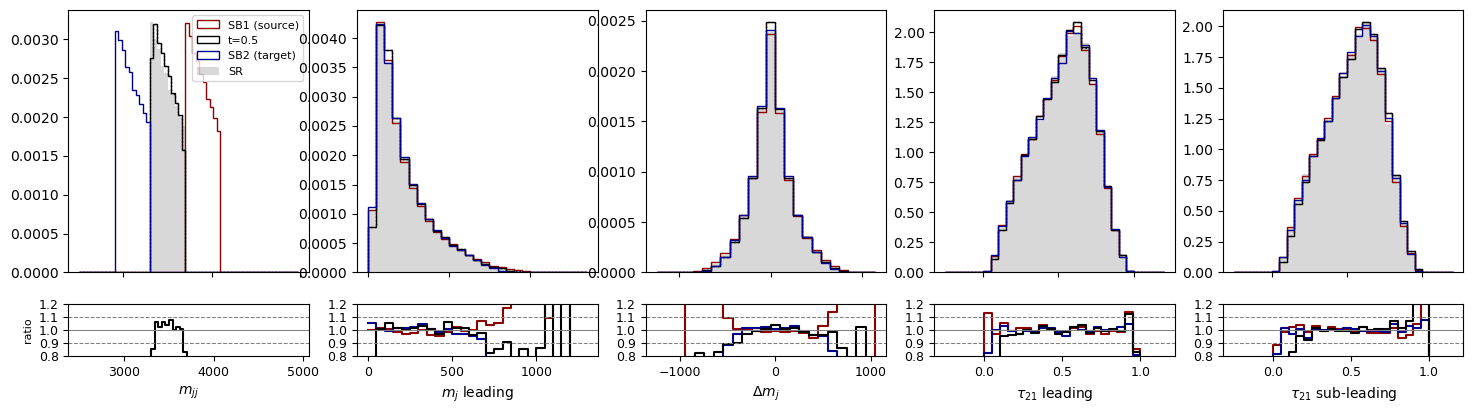

In [ ]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PreProcessLHCOlympicsHighLevelData, PostProcessLHCOlympicsHighLevelData

pipeline_bwd = FlowMatchPipeline(trained_model=cfm_bwd, 
                                configs=configs_bwd, 
                                preprocessor=PreProcessLHCOlympicsHighLevelData,
                                postprocessor=PostProcessLHCOlympicsHighLevelData,
                                best_epoch_model=True)

pipeline_bwd.generate_samples(input_source=lhco_bwd.source)

from utils import plot_interpolation

plot_interpolation(lhco_bwd, 
                   pipeline_bwd, 
                   figsize=(18,4.5),
                   mass_window=[configs_bwd.cuts_sideband_low['mjj'][1], configs_bwd.cuts_sideband_high['mjj'][0]], 
                   bins=[(2500, 5000, 40), (0, 1400, 50), (-1250, 1250, 100), (-0.25, 1.25, 0.05), (-0.25, 1.25, 0.05)], 
                   log=False, 
                   density=True)

# Sample from Pretrained CFM

Load a previsoiusly trained model that was stored somewhere in a directory. The directory must contain the follwing files:
- `config.json` file with all the parameters used during the training.
- `best_epoch_model.pth` model file corresponding the trained model that had the lowest validation loss.
- `last_epoch_model.pth` model file corresponding the last epoch trained model.


### Load pre-trained model and generate samples

### Optimal Transport

In [1]:

from DynGenModels.configs.lhco_configs import LHCOlympics_HighLevel_MLP_CondFlowMatch as Configs
from DynGenModels.datamodules.lhco.datasets import LHCOlympicsHighLevelDataset
from DynGenModels.datamodules.lhco.dataloader import LHCOlympicsDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.dynamics.cnf.condflowmatch import SchrodingerBridgeFlowMatching

# model_fwd = '../../results/LHCOlympicsHighLevel.SchrodingerBridgeFlowMatching.MLP_fwd.2023.12.10_21h29'
model_fwd = '../../results/LHCOlympicsHighLevel.SchrodingerBridgeFlowMatching.MLP_forward.2023.12.08_20h51'

configs_fwd = Configs().load(model_fwd + '/config.json')
configs_fwd.DEVICE = 'cuda:2' 
configs_fwd.workdir = model_fwd 
lhco_fwd = LHCOlympicsHighLevelDataset(configs_fwd)
cfm_fwd  = DynGenModelTrainer(dynamics = SchrodingerBridgeFlowMatching(configs_fwd),
                                model = MLP(configs_fwd), 
                                dataloader = LHCOlympicsDataLoader(lhco_fwd , configs_fwd), 
                                configs = configs_fwd)
cfm_fwd.load(model='best')

2023-12-10 21:01:11.621318: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-10 21:01:12.210390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


+-----------------------------+--------------------------------------------------------------------------+
| Parameters                  | Values                                                                   |
+-----------------------------+--------------------------------------------------------------------------+
| DATA                        | LHCOlympicsHighLevel                                                     |
| dataset                     | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features                    | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input                   | 5                                                                        |
| exchange_target_with_source | False                                                                    |
| preprocess                  | ['standardize']                                                          |
| cuts_sideband_low           | mjj: 

/home/df630/DynGenModels/src/DynGenModels/datamodules/lhco/datasets.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  dijets = torch.Tensor(f['jet features'])


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.85/0.15/0.0
INFO: train size: 63891, validation size: 11274, testing sizes: 0


In [2]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.lhco.dataprocess import PreProcessLHCOlympicsHighLevelData, PostProcessLHCOlympicsHighLevelData

pipeline_fwd = FlowMatchPipeline(trained_model=cfm_fwd, 
                                 configs=configs_fwd, 
                                #  preprocessor=PreProcessLHCOlympicsHighLevelData,
                                 best_epoch_model=True)

pipeline_fwd.generate_samples(input_source=lhco_fwd.source_test_preprocess)

INFO: neural ODE solver with midpoint method and steps=1000


  0%|          | 0/167 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


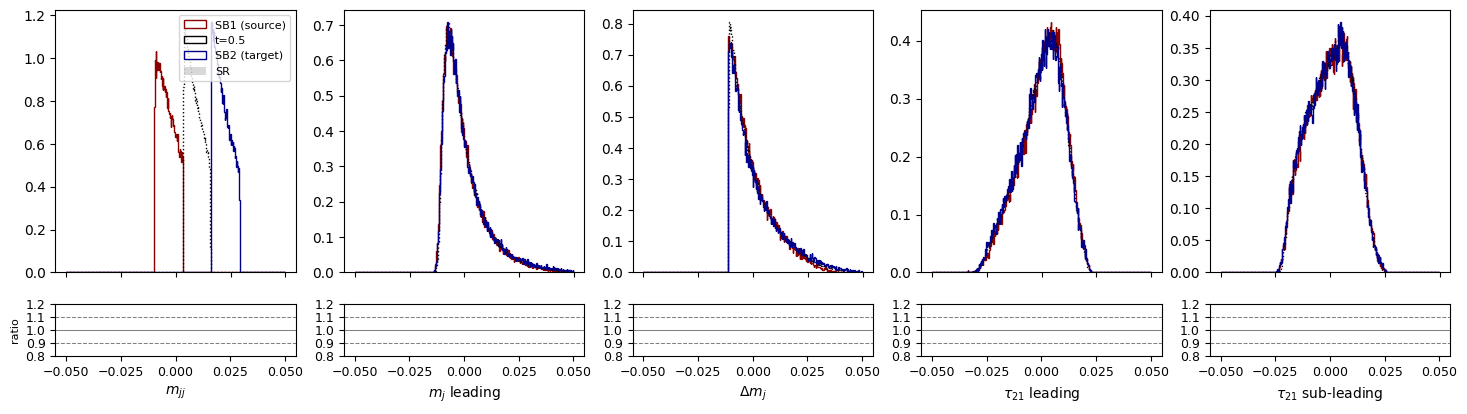

In [7]:
from utils import plot_interpolation

mjj_buffer = 100

plot_interpolation(lhco_fwd, 
                   pipeline_fwd, 
                   figsize=(18,4.5),
                   preprocess=True,
                   mass_window=[configs_fwd.cuts_sideband_low['mjj'][1] + mjj_buffer, configs_fwd.cuts_sideband_high['mjj'][0] - mjj_buffer], 
                #    bins=[(configs_fwd.cuts_sideband_low['mjj'][0] - mjj_buffer, configs_fwd.cuts_sideband_high['mjj'][1] + mjj_buffer, 15), (0, 1200, 20), (-1250, 1250, 40), (0, 1.1, 0.02), (0, 1.1, 0.02)], 
                   bins = [(-5, 5, 0.02), (-5, 5, 0.02), (-5, 5, 0.02), (-5, 5, 0.02), (-5, 5, 0.02)],
                   log=False, 
                   density=True)

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


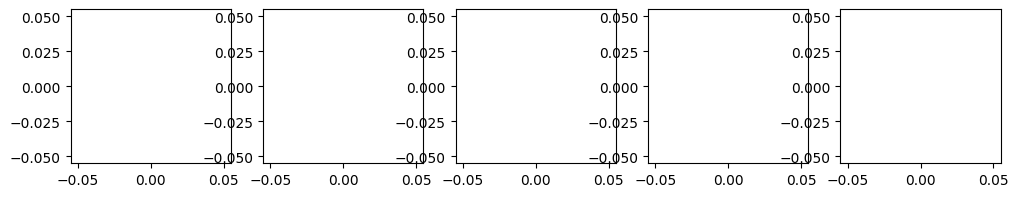

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def sample_interpolation(lhco, pipeline, mass_window=[3300,3700]):     
    x = torch.mean(pipeline.trajectories[...,0], dim=-1) - lhco.background[...,0].mean()
    idx = torch.argmin(torch.abs(x))
    interpolation = pipeline.trajectories[idx]  
    mask = (interpolation[...,0] > mass_window[0]) & (interpolation[...,0] < mass_window[1])
    return interpolation[mask]


interpolation = sample_interpolation(lhco_fwd, pipeline_fwd, mass_window=[3300,3700])

fig, ax = plt.subplots(1, 5, figsize=(12, 2))
ax[0].hist(interpolation[:,0], bins=50, density=True)
ax[1].hist(interpolation[:,1], bins=50, density=True)
ax[2].hist(interpolation[:,2], bins=50, density=True)
ax[3].hist(interpolation[:,3], bins=50, density=True)
ax[4].hist(interpolation[:,4], bins=50, density=True)
plt.show()



In [12]:
import h5py
import pandas as pd
import numpy as np

with h5py.File(model_fwd + '/events_generated_interpolation.h5', 'w') as f:
    f.create_dataset('jet high level features', data=interpolation)

In [ ]:
from utils import load_bridge_pipelines
from DynGenModels.dynamics.cnf.condflowmatch import SchrodingerBridgeFlowMatching

model_fwd = '../../results/LHCOlympics.SchrodingerBridgeFlowMatching.MLP_forward.2023.11.30_20h33'

pipe_fwd, pipe_bwd, lhco_fwd, lhco_bwd = load_bridge_pipelines(model_fwd, 
                                                               model_bwd, 
                                                               bridge=SchrodingerBridgeFlowMatching, 
                                                               device='cpu')


+-----------------------------+--------------------------------------------------------------------------+
| Parameters                  | Values                                                                   |
+-----------------------------+--------------------------------------------------------------------------+
| DATA                        | LHCOlympics                                                              |
| dataset                     | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features                    | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input                   | 5                                                                        |
| exchange_target_with_source | False                                                                    |
| preprocess                  | ['normalize']                                                            |
| cuts_sideband_low           | mjj: 

/Users/dario/Dropbox/PROJECTS/ML/DynGenModels/src/DynGenModels/datamodules/lhco/datasets.py:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:233.)
  dijets = torch.Tensor(f['jet features'])


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.85/0.15/0.0
INFO: train size: 56652, validation size: 9997, testing sizes: 0
+-----------------------------+--------------------------------------------------------------------------+
| Parameters                  | Values                                                                   |
+-----------------------------+--------------------------------------------------------------------------+
| DATA                        | LHCOlympics                                                              |
| dataset                     | ../../data/LHCOlympics2020/events_anomalydetection_high_level_cathode.h5 |
| features                    | ['mjj', 'mj1', 'delta_m', 'tau21_1', 'tau21_2']                          |
| dim_input                   | 5                                                                        |
| exchange_target_with_source | False                                                                    |


/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


INFO: neural ODE solver with midpoint method and steps=1000


/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_76816/2645530005.py:131: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.8, 1.2, 0)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_76816/2645530005.py:138: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(9)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_76816/2645530005.py:140: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(9)


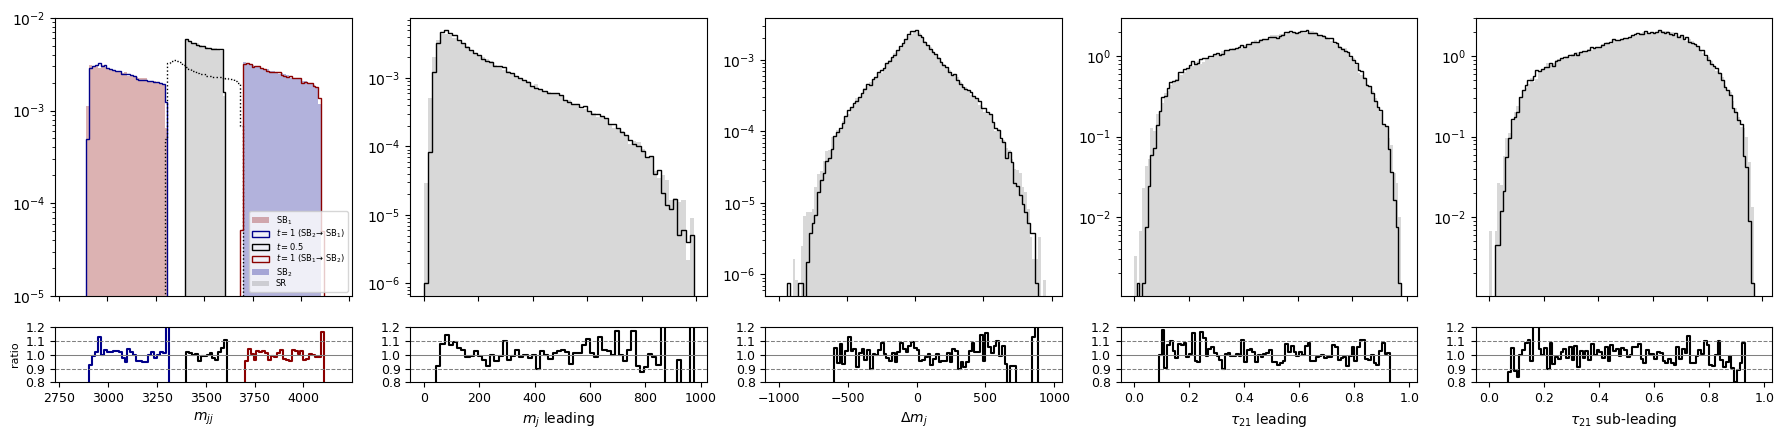

$t_f=$0.49799999594688416, $t_b=0.5019999742507935$


/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_76816/2645530005.py:258: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.8, 1.2, 0)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_76816/2645530005.py:263: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  for tick in ax_ratio.xaxis.get_major_ticks(): tick.label.set_fontsize(9)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_76816/2645530005.py:264: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  for tick in ax_ratio.yaxis.get_major_ticks(): tick.label.set_fontsize(9)


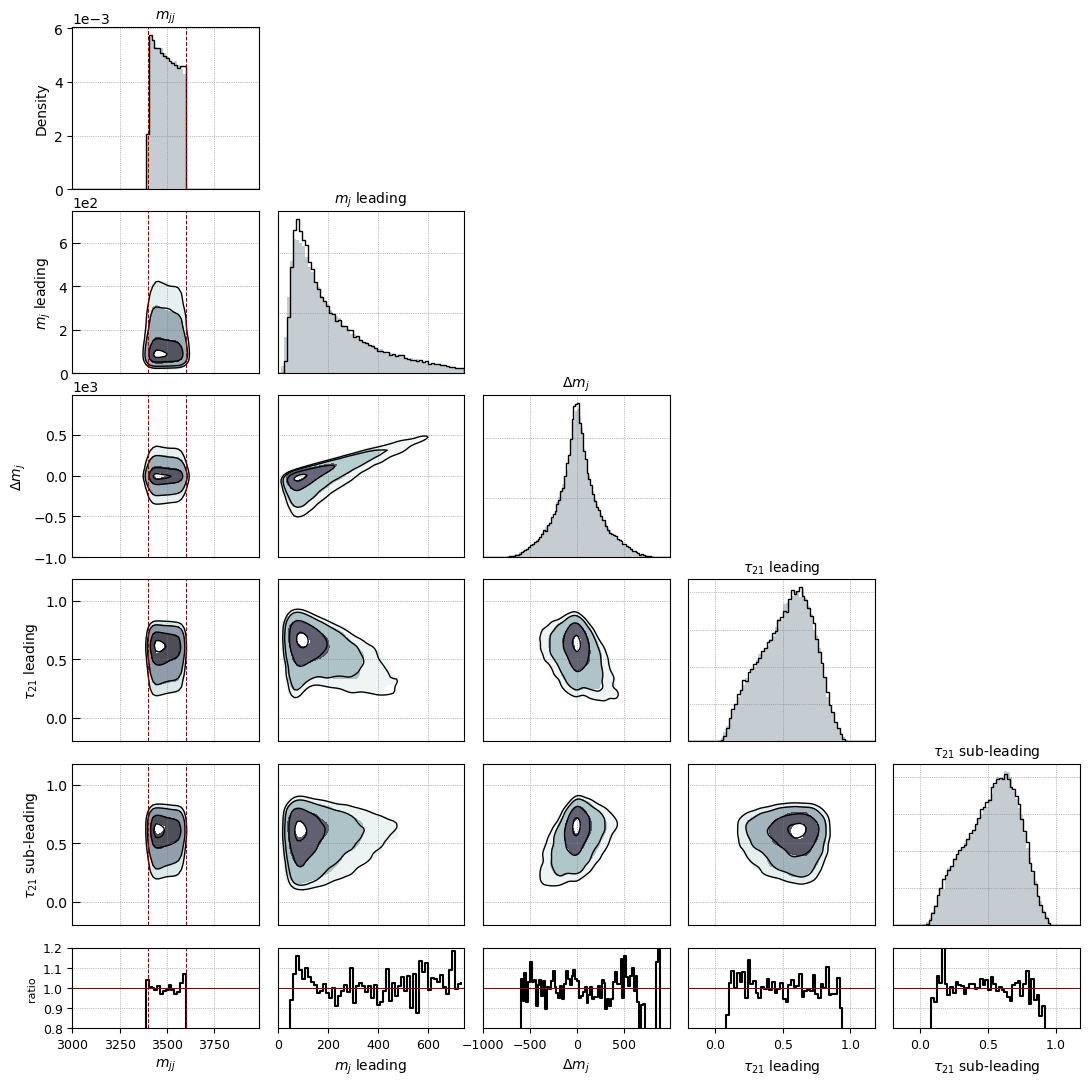

$t_f=$0.49799999594688416, $t_b=0.5019999742507935$


/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_76816/2645530005.py:392: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax_ratio.set_ylim(0.8, 1.2, 0)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_76816/2645530005.py:397: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  for tick in ax_ratio.xaxis.get_major_ticks(): tick.label.set_fontsize(9)
/var/folders/qf/b744x74x1633_slts1tp1w800000gn/T/ipykernel_76816/2645530005.py:398: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  for tick in ax_ratio.yaxis.get_major_ticks(): tick.label.set_fontsize(9)


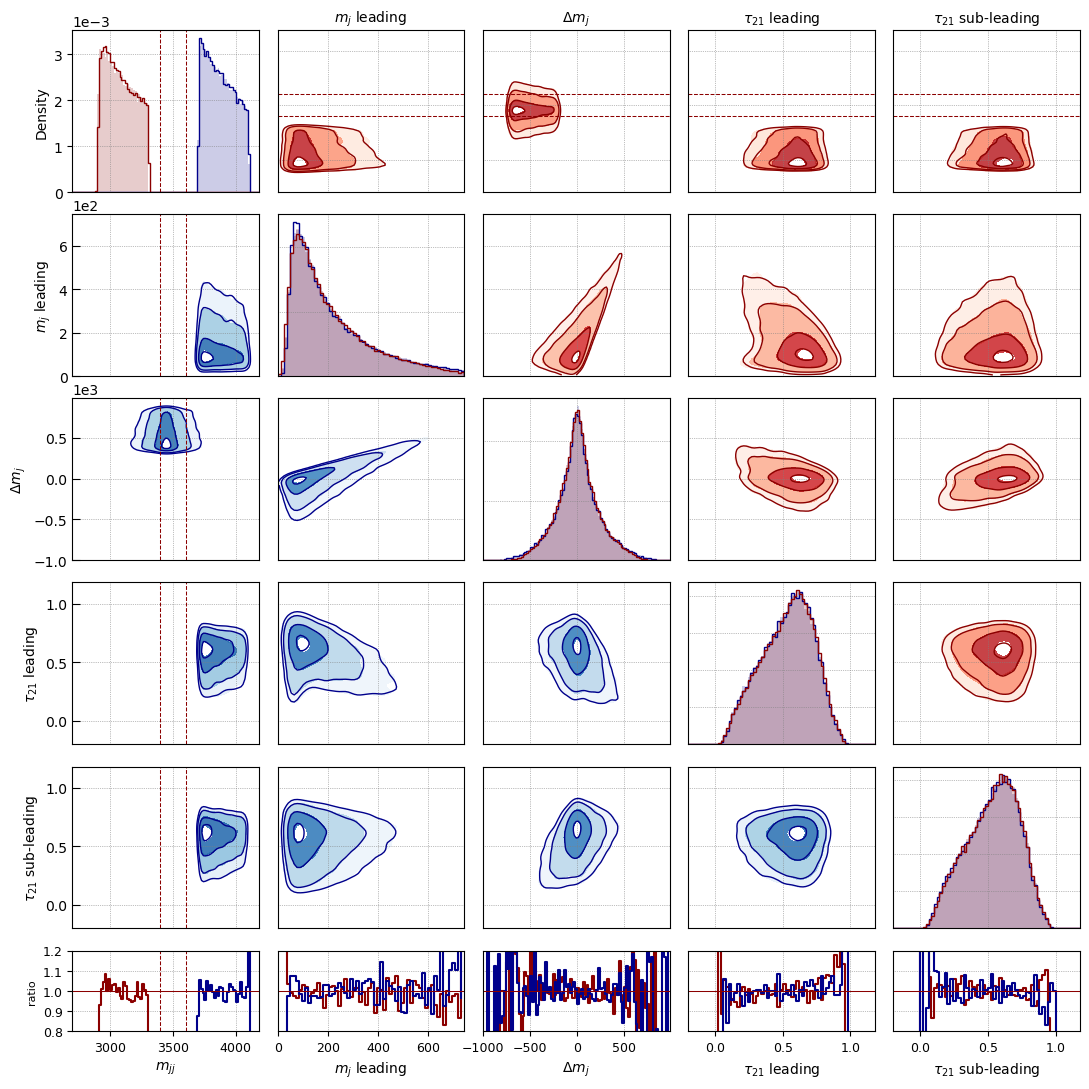

In [ ]:
# from utils import plot_interpolation_combined, plot_interpolation_combined_corner, plot_marginal_fits_corner

plot_interpolation_combined(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(18, 4.5),
                            mass_window=[3300+mjj_buffer, 3700-mjj_buffer], 
                            bins=[(2800, 4200, 15), (0, 1000, 15), (-1000, 1000, 20), (0, 1, 0.01), (0, 1., 0.01)], 
                            log=True, 
                            density=True,
                            save_path_fwd=model_fwd + '/interpolation_combined.png',
                            save_path_bwd=model_bwd + '/interpolation_combined.png')

plot_interpolation_combined_corner(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(13,13),
                                    mass_window=[3300+mjj_buffer, 3700-mjj_buffer], 
                                    bins=[(3000, 4000, 15), (0, 750, 12), (-1000, 1000, 20), (-0.2, 1.2, 0.02), (-0.2, 1.2, 0.02)], 
                                    log=False, 
                                    density=True,
                                    save_path_fwd=model_fwd + '/interpolation_corner_plot.pdf',
                                    save_path_bwd=model_bwd + '/interpolation_corner_plot.pdf')

plot_marginal_fits_corner(lhco_fwd, pipe_fwd, pipe_bwd, figsize=(13,13),
                            mass_window=[3300+mjj_buffer, 3700-mjj_buffer], 
                            bins=[(2700, 4200, 15), (0, 750, 12), (-1000, 1000, 20), (-0.2, 1.2, 0.02), (-0.2, 1.2, 0.02)], 
                            log=False, 
                            density=True,
                            save_path_fwd=model_fwd + '/marginals_corner_plots.pdf',
                            save_path_bwd=model_bwd + '/marginals_corner_plots.pdf')